## //TODO: Get Y Labels
#### You should probably do this in API.py, so that there can be a different method you call from this cell which chooses tickers, calls getSamples to retrieve the requested X data, selects the samples we want from the X data, and then calculates Y using the <date> in X

In [1]:
import os
import requests
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler

import statsmodels.tsa.api as tsa
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

from api_keys import fmp_api_key as api_key
from API import API

api = API(api_key, period='quarter', limit=None)
tickers = api.getRandTickers(50)
# tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']

X = api.getSamplesFromTickers(tickers, samplesPerTicker=100, maxTickers=50)
Y = api.getYFromDF(X)


Date 2017-09-30 not found for EGP
Date 1990-03-31 not found for EGP
Date 2000-09-30 not found for EGP
Date 1994-09-30 not found for EGP
Date 2007-09-30 not found for EGP
Date 1995-12-31 not found for EGP
Date 2011-06-30 not found for EGP
Date 2018-09-30 not found for EGP
Date 2012-09-30 not found for EGP
Date 2002-06-30 not found for EGP
Date 2006-09-30 not found for EGP
Date 2007-06-30 not found for EGP
Date 2007-03-31 not found for EGP
Date 1991-06-30 not found for EGP
Date 1994-12-31 not found for EGP
Date 2005-12-31 not found for EGP
Date 2013-03-31 not found for EGP
Date 2011-12-31 not found for EGP
Date 1996-03-31 not found for EGP
Date 2010-12-31 not found for EGP
Date 2001-09-30 not found for EGP
Date 2011-09-30 not found for EGP
Date 2002-03-31 not found for EGP
Date 2006-03-31 not found for EGP
Date 2017-03-31 not found for EGP
Date 2011-03-31 not found for EGP
Date 2016-09-30 not found for EGP
Date 2000-03-31 not found for EGP
Date 2004-12-31 not found for EGP
Date 2019-06-3

## Format X and Y Data

In [2]:
print(tickers)

baselinePercentage = .06
Y['baselinePercentage'] = Y.apply(lambda row: baselinePercentage, axis=1)

merged = pd.merge(X, Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()

['TGIF', 'IWF', 'NMIAX', '1999.HK', 'ORE.AX', 'XSMO', 'FGP.L', 'HBMD', '0KW8.L', 'TRRHX', 'HSIC', '0QYY.L', 'USAQ', 'RGP', 'HCO.PA', '2051.HK', 'FIPP.PA', 'HEROMOTOCO.NS', 'ALICON.NS', 'DRNA', 'IPOE', 'PRSRU', 'TPL', 'UCC', 'VFQY', 'EGP', 'ASWN.SW', 'FMBM', 'RAJRAYON.NS', 'CHND', 'DVN.AX', 'HYLB', 'BIGFX', 'EPR', '3999.HK', 'ESN.TO', 'WPR.AX', 'ARCM.L', 'CHALET.NS', 'DSP', 'PFS.NS', 'TCBK', 'WIPRO.NS', 'TYMN.L', 'IGI', 'MCRI', '6119.HK', 'ABEA.DE', 'SVB.TO', 'FLCSX']


In [3]:
X = merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage', 'baselinePercentage'], axis=1)
Y = merged[['percentage']]
Y_baseline = merged[['baselinePercentage']]

In [4]:
# display(merge)
display(X.head())
print(X.columns)
print(X.shape)
display(Y.head())
print(Y.shape)
display(Y_baseline.head())
print(Y_baseline.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,1.288310,0.692333,0.270863,0.060526,-0.024767,-0.066388,0.043237,1.576740,3.386686,2.966095,...,0.000000e+00,0.000000,0.000000,-0.005577,-1.506283,-0.100542,-2.369742,-2.364065,9.867238e+09,9.768392e+09
2,1.452791,0.592427,0.271531,0.072690,0.105342,0.292672,0.047903,1.477748,3.015425,2.555071,...,-8.274378e-07,-0.000049,-0.000035,-0.000053,8.265275,-0.000037,-97.805647,-95.447666,8.477864e+09,8.319865e+09
3,1.715197,0.966653,0.279645,0.062896,-0.026464,-0.059555,0.038257,1.054811,1.774558,1.820947,...,-9.105832e-04,0.002266,0.002254,0.035836,-0.327347,-0.000127,-2.461715,-3.911466,5.230907e+09,5.184536e+09
4,1.484296,0.824242,0.281538,0.066360,0.027291,0.067019,0.042544,1.194678,2.017365,1.923691,...,1.333333e-05,0.000024,0.000010,-0.000076,0.067524,-0.000165,0.327626,1.591598,5.622849e+09,5.578565e+09
6,1.442712,0.744096,0.278096,0.064011,0.024438,0.066652,0.040751,1.493099,3.011984,2.714139,...,0.000000e+00,0.000000,0.000000,0.000000,-0.079832,-0.017922,0.379452,0.328902,8.740718e+09,8.655647e+09


Index(['currentRatio', 'quickRatio', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnEquity',
       'returnOnCapitalEmployed', 'debtEquityRatio', 'priceToBookRatio',
       'priceToSalesRatio', 'priceEarningsRatio', 'priceEarningsToGrowthRatio',
       'priceToOperatingCashFlowsRatio', 'growthRevenue',
       'growthCostOfRevenue', 'growthGrossProfit', 'growthGrossProfitRatio',
       'growthOperatingExpenses', 'growthEBITDA', 'growthOperatingIncome',
       'growthNetIncome', 'growthEPS', 'marketCapitalization',
       'enterpriseValue'],
      dtype='object')
(45, 24)


,percentage
0,-0.041695
2,0.113489
3,0.092828
4,-0.193055
6,0.232488


(45, 1)


,baselinePercentage
0,0.06
2,0.06
3,0.06
4,0.06
6,0.06


(45, 1)


## Plot Features to Examine Distributions

<ipython-input-5-a0f12a0a1394>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


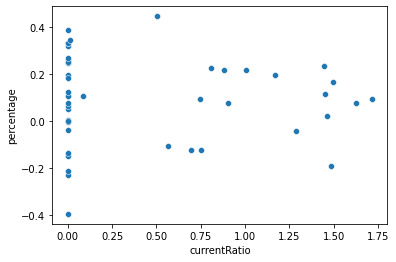

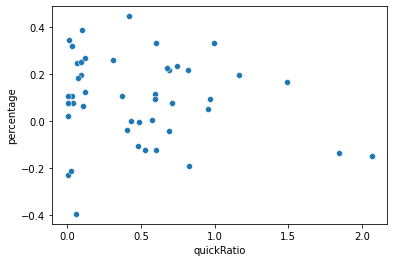

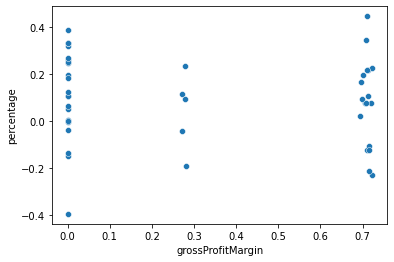

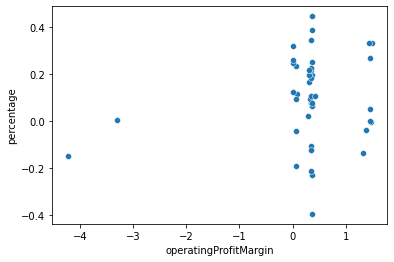

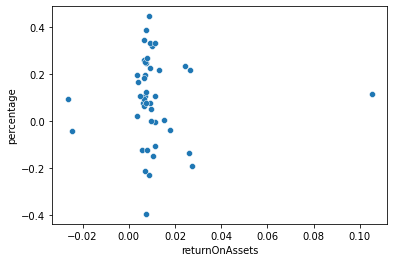

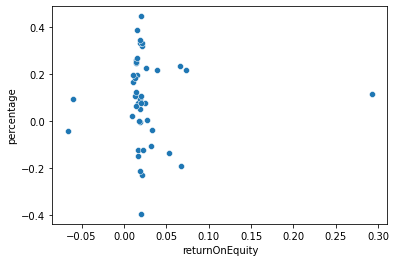

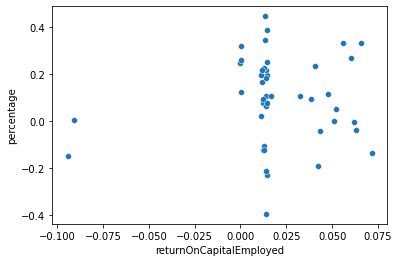

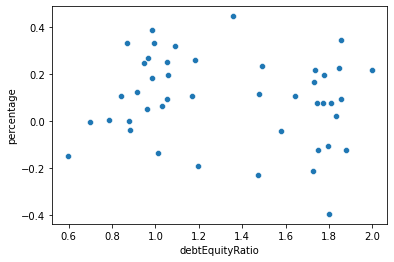

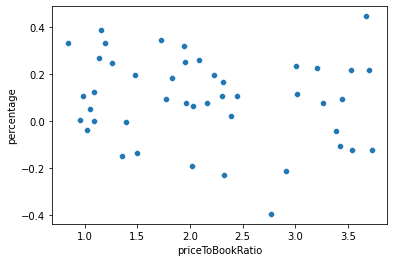

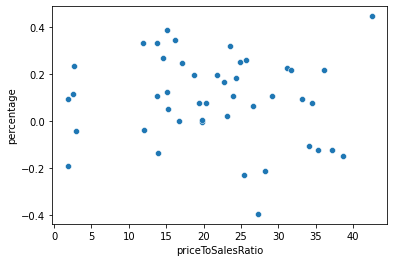

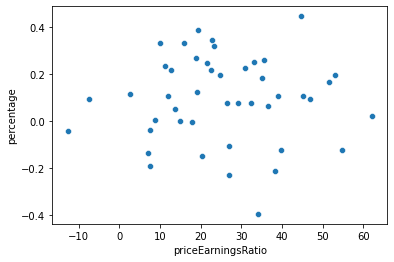

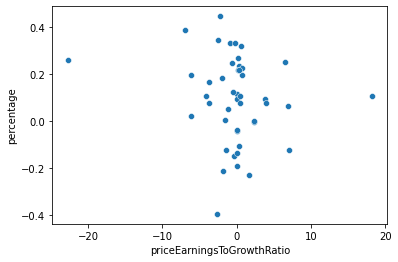

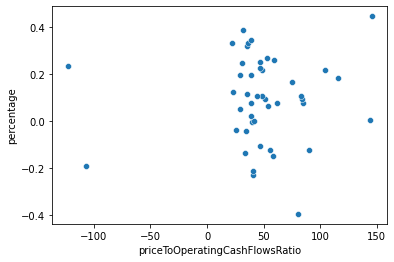

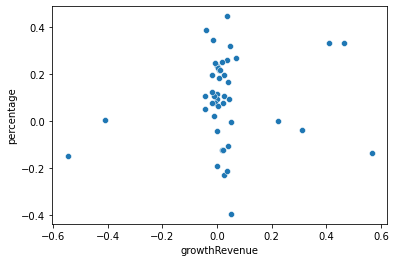

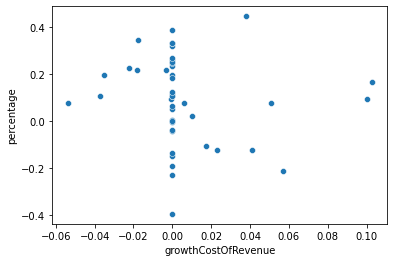

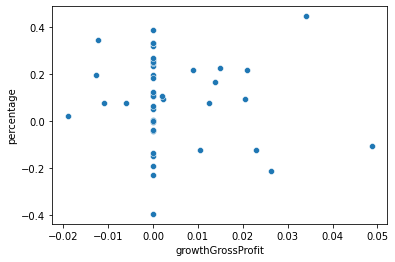

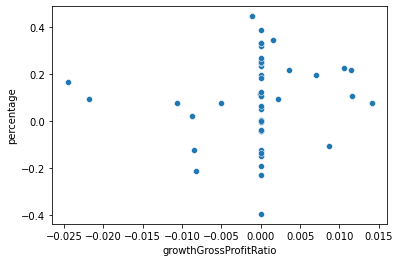

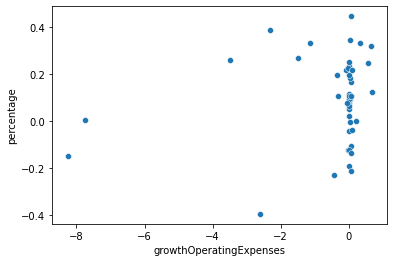

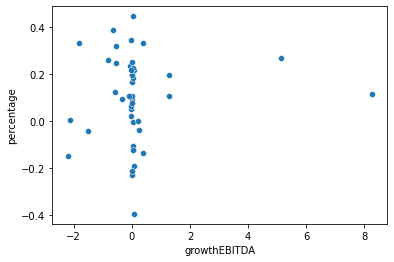

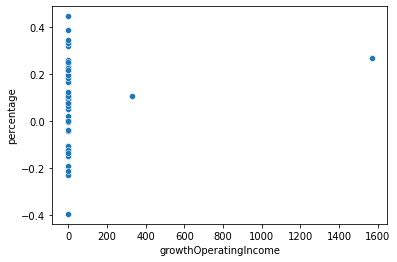

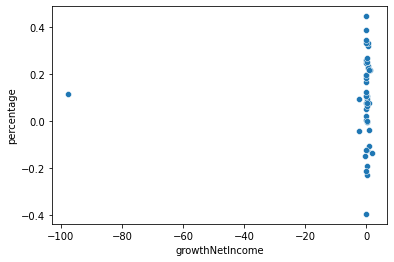

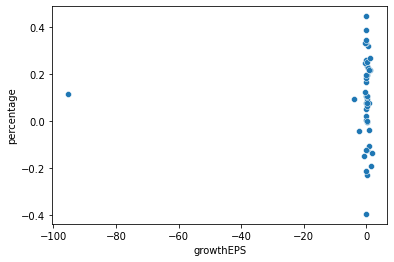

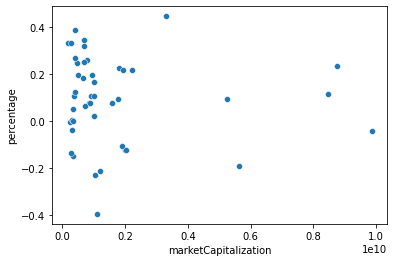

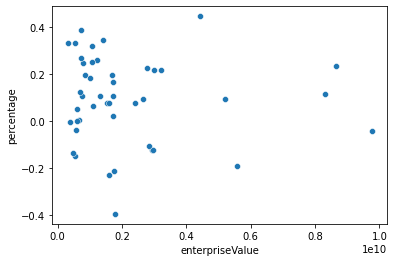

In [5]:
for colName in X:
  plt.figure()
  sns.scatterplot(data=merged, x=colName, y='percentage')

## Scaling/ Normalization

In [6]:
# min_max_scaler = MinMaxScaler((-1, 1))
# df[percentages] = min_max_scaler.fit_transform(df[percentages])  # No need, because percentages are already on a good scale
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X), columns = X.columns)
display(X_scaled.head())



,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,1.418345,0.419757,-0.131746,-0.236697,-2.073946,-1.984639,0.760404,0.591392,1.352584,-1.807330,...,-0.203561,-0.327958,0.056826,0.310995,-1.031118,-0.178979,-0.015850,-0.018858,3.603170,3.491960
1,1.695496,0.213005,-0.129740,-0.224463,5.558661,5.767763,0.909418,0.348999,0.940640,-1.847498,...,-0.203590,-0.332017,0.051741,0.314085,5.090577,-0.178553,-6.625933,-6.620918,2.991205,2.827443
2,2.137650,0.987455,-0.105408,-0.234313,-2.173509,-1.837111,0.601357,-0.686610,-0.436202,-1.919242,...,-0.235851,-0.139606,0.382539,0.334164,-0.292537,-0.178553,-0.022221,-0.128609,1.561048,1.389097
3,1.748581,0.692738,-0.099731,-0.230829,0.979951,0.895726,0.738283,-0.344130,-0.166789,-1.909201,...,-0.203088,-0.325937,0.058202,0.314072,-0.045158,-0.178553,0.170975,0.261702,1.733683,1.569860
4,1.678513,0.526880,-0.110052,-0.233192,0.812582,0.887811,0.681001,0.386588,0.936823,-1.831953,...,-0.203561,-0.327958,0.056826,0.314115,-0.137474,-0.178629,0.174564,0.172143,3.106982,2.981484


## Reduce Dimensionality with PCA

In [7]:
pca = PCA(n_components='mle')
X_pc = pca.fit_transform(X_scaled)
# print(pca.components_)
# print(pca.explained_variance_)
display(X_pc.shape)

(45, 21)

## Examine Distribution on 1st Principle Component

In [8]:
# plt.scatter(X_pc[:,0], Y)
print(X_pc[:,0].shape)
print(Y.shape)
print(Y)

(45,)
(45, 1)
    percentage
0    -0.041695
2     0.113489
3     0.092828
4    -0.193055
6     0.232488
7     0.195104
8    -0.124552
9     0.247037
10    0.165077
11   -0.147399
12    0.077529
13    0.183447
14    0.108525
15   -0.003106
16    0.003390
17    0.194772
18    0.050623
19   -0.230303
21    0.388889
22    0.446310
24    0.317771
25   -0.105793
26    0.332487
27   -0.121762
28    0.020332
29    0.258355
30    0.076566
31    0.093043
32    0.105538
33    0.105332
36    0.250668
37   -0.039735
38    0.061972
39    0.333333
40    0.000000
41    0.122424
44    0.215903
49    0.344496
50   -0.137143
52    0.269804
53    0.075885
54   -0.395824
55    0.225680
56    0.217989
57   -0.212608


## Transform Data to Polynomial Features, Train Models, and Plot Error

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def trainAndGetResults(X, baseline=False):
    results = {'clf': [] , 'x': [], 'X_train': [], 'Y_pred': [], 'Y_test': [], 'mse': [], 'rmse': []}
    for i in range(1, 5):
        if not baseline:
            print("X Shape = ")
            print(X.shape)
            poly = PolynomialFeatures(degree=i)
            poly_features = poly.fit_transform(X)
            X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size=0.33, random_state=42)

            clf = LinearRegression()
            print("Poly Shape = ")
            print(poly_features.shape)
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test)
            results['clf'].append(clf)
            results['X_train'].append(X_train)
            results['Y_pred'].append(Y_pred)
            results['Y_test'].append(Y_test)

            mse = mean_squared_error(Y_test, Y_pred)
            rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        else:
            mse = mean_squared_error(Y, Y_baseline)
            rmse = mean_squared_error(Y, Y_baseline, squared=False)

        results['x'].append(i)
        results['mse'].append(mse)
        results['rmse'].append(rmse)
    return results

trueBaseResults = trainAndGetResults(X)
baselineBaseResults = trainAndGetResults(X, baseline=True)
truePcResults = trainAndGetResults(X_pc)
baselinePcResults = trainAndGetResults(X_pc, baseline=True)

X Shape = 
(45, 24)
Poly Shape = 
(45, 25)
X Shape = 
(45, 24)
Poly Shape = 
(45, 325)
X Shape = 
(45, 24)
Poly Shape = 
(45, 2925)
X Shape = 
(45, 24)
Poly Shape = 
(45, 20475)
X Shape = 
(45, 21)
Poly Shape = 
(45, 22)
X Shape = 
(45, 21)
Poly Shape = 
(45, 253)
X Shape = 
(45, 21)
Poly Shape = 
(45, 2024)
X Shape = 
(45, 21)
Poly Shape = 
(45, 12650)


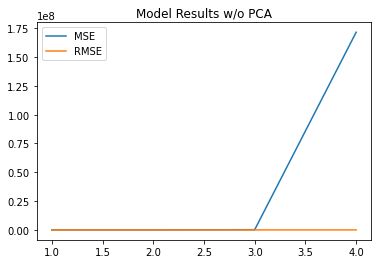

MSEs: [61.48994848420741, 10088.872386893954, 201060.7245410326, 171540756.77751178]
RMSEs: [7.841552683251411, 100.4433790097384, 448.39795331940644, 13097.356862264684]

1's top 3 weights were [40.66902314  7.02175808  6.2561939 ]
at [ 6 16  7]
2's top 3 weights were [2.28198654e-09 1.83868677e-09 1.81046709e-09]
at [187  47 308]
3's top 3 weights were [1.66876233e-18 1.65867934e-18 1.47979271e-18]
at [2106 2107 2887]
4's top 3 weights were [4.12830553e-27 2.15236977e-27 2.08241055e-27]
at [16598 11619 16597]


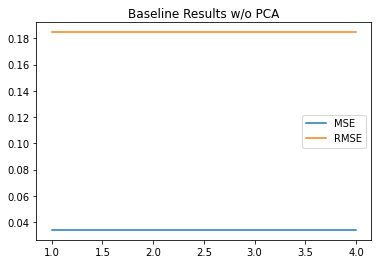

MSEs: [0.03407703098033303, 0.03407703098033303, 0.03407703098033303, 0.03407703098033303]
RMSEs: [0.18459965054228308, 0.18459965054228308, 0.18459965054228308, 0.18459965054228308]



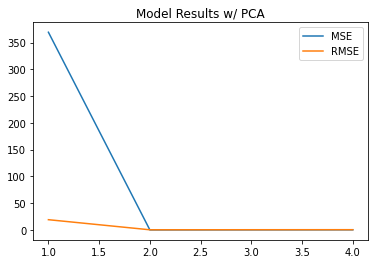

MSEs: [369.1547133514579, 0.12880841492118014, 0.21836144743406435, 0.2996038158332671]
RMSEs: [19.213399317961876, 0.35889889233763334, 0.4672916085637151, 0.5473607730128888]

1's top 3 weights were [2.40191893 2.3135342  1.8614566 ]
at [15 21  4]
2's top 3 weights were [0.03467807 0.0324121  0.03217072]
at [47 23 74]
3's top 3 weights were [0.01091454 0.00952562 0.00906259]
at [485 486 493]
4's top 3 weights were [0.00322867 0.00227073 0.00180938]
at [3799 4005  490]


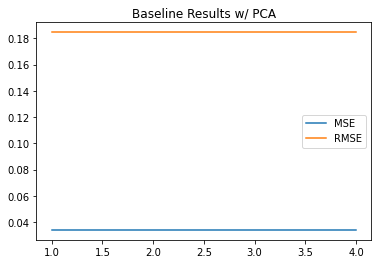

MSEs: [0.03407703098033303, 0.03407703098033303, 0.03407703098033303, 0.03407703098033303]
RMSEs: [0.18459965054228308, 0.18459965054228308, 0.18459965054228308, 0.18459965054228308]



In [10]:
def plotResults(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()
    for x, clf in zip(results['x'], results['clf']):
        coef = clf.coef_.ravel()
        max_3_idx = coef.argsort()[-3:][::-1]
        print("{}'s top 3 weights were {}".format(x, coef[max_3_idx]))
        print("at {}".format(max_3_idx))

plotResults(trueBaseResults, "Model Results w/o PCA")
plotResults(baselineBaseResults, "Baseline Results w/o PCA")
plotResults(truePcResults, "Model Results w/ PCA")
plotResults(baselinePcResults,"Baseline Results w/ PCA")


## Real-World Results

In [28]:
# Collect data from 10 different stocks
final_tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']
final_pca = PCA(n_components=21)
final_poly = PolynomialFeatures(degree=1)

spy_X = api.getSamplesFromTickers(final_tickers, samplesPerTicker=50, maxTickers=10)
spy_Y = api.getYFromDF(spy_X)

Date 2002-06-29 not found for AAPL
Date 2003-06-28 not found for AAPL
Date 2010-12-25 not found for AAPL
Date 2000-07-01 not found for AAPL
Date 2002-03-30 not found for AAPL
Date 1994-04-01 not found for AAPL
Date 2016-12-31 not found for AAPL
Date 2009-03-28 not found for AAPL
Date 2012-09-29 not found for AAPL
Date 2018-12-29 not found for AAPL
Date 2010-09-25 not found for AAPL
Date 1998-09-25 not found for AAPL
Date 2016-03-26 not found for AAPL
Date 2007-03-31 not found for AAPL
Date 2008-06-28 not found for AAPL
Date 2005-12-31 not found for AAPL
Date 1991-06-30 not found for AAPL
Date 2019-06-29 not found for AAPL
Date 2012-03-31 not found for AAPL
Date 2011-09-24 not found for AAPL
Date 2019-09-28 not found for AAPL
Date 1998-12-26 not found for AAPL
Date 1997-09-26 not found for AAPL
Date 2009-12-26 not found for AAPL
Date 2007-12-29 not found for AAPL
Date 1995-12-29 not found for AAPL
Date 1997-12-26 not found for AAPL
Date 2005-06-25 not found for AAPL
Date 1989-12-31 not 

In [33]:
spy_merged = pd.merge(spy_X, spy_Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()
spy_X = spy_merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage'], axis=1)
spy_Y = spy_merged[['percentage']]

spy_X_scaled = pd.DataFrame(ss.fit_transform(spy_X), columns = spy_X.columns)
spy_X_pc = final_pca.fit_transform(spy_X_scaled)
spy_X_poly = final_poly.fit_transform(spy_X_scaled)
spy_X_pc_poly = final_poly.fit_transform(spy_X_pc)

In [34]:
display(spy_X.head())

print(spy_X.shape)
print(spy_Y.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,2.521323,1.243205,0.476095,0.115561,0.031957,0.062082,0.072770,0.942679,2.759181,3.363595,...,0.289973,0.145018,-0.060306,-0.287359,-9.849858,-3.957207,-4.126177,-4.090608,5.853327e+09,5.302227e+09
1,1.869350,0.790864,0.347691,-0.164715,-0.039492,-0.093195,-0.114835,1.359812,2.244632,2.435703,...,0.019130,-0.056921,-0.044308,0.038228,-0.243754,-0.297757,-0.312461,-0.313440,4.535280e+09,4.450280e+09
2,5.289157,2.077453,0.879959,0.348932,0.059042,0.068936,0.098933,0.167580,7.108992,25.073118,...,-0.163121,-0.036748,0.018127,-0.005714,-0.067961,-0.080429,-0.098113,-0.083019,2.464688e+10,2.380388e+10
3,2.942436,0.984329,0.967620,0.532760,0.065822,0.088005,0.110123,0.337011,14.267148,69.022246,...,0.939394,-0.026470,-0.016126,-0.143071,0.052510,0.095164,0.240236,0.242240,2.728449e+11,2.676539e+11
4,2.352882,2.215695,0.612933,0.203260,0.016118,0.043363,0.031190,1.690307,5.573498,19.466146,...,0.033282,-0.013584,-0.017556,0.122110,-0.127325,-0.206890,-0.168797,-0.166667,4.012751e+11,4.484521e+11


(104, 24)
(104, 1)


In [38]:
r1 = trueBaseResults['clf'][0].predict(spy_X_poly)
r2 = truePcResults['clf'][0].predict(spy_X_pc_poly)

r1MSE = mean_squared_error(spy_Y, r1)
r2MSE = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE)
print(r2MSE)
print(baseMSE)

11084.248883815353
148.43389544750994
2.3740382234597415
